In [1]:
import numpy as np
import scipy
from scipy.interpolate import BSpline
from scipy.interpolate import _bspl

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 200
textsize = 'x-large'
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize': 'medium',
         'xtick.labelsize': 'medium',
         'ytick.labelsize': 'medium',
         'figure.autolayout': True,
         'figure.figsize': (4,3),
         'text.usetex': True,
         'text.latex.preamble': [r"\usepackage{bm}"]}
pylab.rcParams.update(params)

from colors_labels import *
import bao_utils

In [2]:
import Corrfunc
from Corrfunc.io import read_lognormal_catalog, read_fortran_catalog
from Corrfunc.theory.DDsmu import DDsmu
from Corrfunc.theory.DD import DD
from Corrfunc.theory.xi import xi
from Corrfunc.utils import compute_amps
from Corrfunc.utils import evaluate_xi
from Corrfunc.utils import qq_analytic
from Corrfunc.bases import spline, bao

In [3]:
realization = 1
boxsize = 750
nbar = '2e-4'
#nbar = '5e-5'
cat_tag = f'_L{boxsize}_n{nbar}_z057_patchy'
cat_fn = f'../catalogs/lognormal/cat{cat_tag}_lognormal_rlz{realization}.bin'

In [4]:
boxsize = 750.0
x, y, z = read_fortran_catalog(cat_fn)
nd = len(x)
weights = np.array([np.ones(nd), x, y, z])
print("Number of data points:",nd)

Number of data points: 85575


In [5]:
# generate random catalog
randmult = 2
nr = nd*randmult
xr = np.random.rand(nr)*float(boxsize)
yr = np.random.rand(nr)*float(boxsize)
zr = np.random.rand(nr)*float(boxsize)
weights_r = np.array([np.ones(nr), xr, yr, zr])
print("Number of data points:", nr)

Number of data points: 171150


In [6]:
# parameters for all
rmin = 40.0
rmax = 140.0
ntopbins = 10
r_edges = np.linspace(rmin, rmax, ntopbins+1)

ncont = 2000
r_fine = np.linspace(rmin, rmax, ncont)

nmubins = 1
mumax = 1.0
periodic = True
nthreads = 1
verbose = False

## regular tophat

In [7]:
proj_type = 'tophat'
weight_type = None
projfn = None
nprojbins = ntopbins

In [8]:
_, dd_top, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z, weights1=weights, 
                           proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, 
                           periodic=periodic, boxsize=boxsize, verbose=verbose, weight_type=weight_type)
print("DD:", np.array(dd_top))

DD: [ 4533136.  6690100.  9295684. 12332472. 15821900. 19762672. 24114638.
 28845574. 34054206. 39688780.]


In [9]:
_, dr_top, _ = DDsmu(0, nthreads, r_edges, mumax, nmubins, x, y, z, weights1=weights, 
                           X2=xr, Y2=yr, Z2=zr, weights2=weights_r, 
                           proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, 
                           periodic=periodic, boxsize=boxsize, verbose=verbose, weight_type=weight_type)
print("DR:", np.array(dr_top))

DR: [ 8861641. 13218953. 18462934. 24568171. 31547231. 39419230. 48127445.
 57733151. 68198805. 79559673.]


In [10]:
_, rr_top, qq_top = DDsmu(1, nthreads, r_edges, mumax, nmubins, xr, yr, zr, weights1=weights_r, 
                                 proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, 
                                 periodic=periodic, boxsize=boxsize, verbose=verbose, weight_type=weight_type)
print("RR:", np.array(rr_top))
#print("QQ:", np.array(qq_top).reshape(nprojbins, nprojbins))

RR: [1.77404540e+07 2.64760900e+07 3.69214000e+07 4.91463820e+07
 6.31097340e+07 7.88137240e+07 9.62716580e+07 1.15451238e+08
 1.36440456e+08 1.59092948e+08]


In [11]:
amps_top = compute_amps(nprojbins, nd, nd, nr, nr, dd_top, dr_top, dr_top, rr_top, qq_top)

In [12]:
xi_top = evaluate_xi(amps_top, r_fine, proj_type, rbins=r_edges)

## tophat basis with xyz dependence ("gradient")

In [13]:
proj_type = 'gradient'
weight_type = 'pair_product_gradient'
projfn = None
nprojbins = ntopbins*4

In [14]:
dd_res, dd_proj, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z, weights1=weights, 
                           proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, 
                           periodic=periodic, boxsize=boxsize, verbose=verbose, weight_type=weight_type)
print("DD:", np.array(dd_proj))

DD: [ 4.53313600e+06  6.69010000e+06  9.29568400e+06  1.23324720e+07
  1.58219000e+07  1.97626720e+07  2.41146380e+07  2.88455740e+07
  3.40542060e+07  3.96887800e+07 -2.84614220e+07 -4.04330744e+07
 -5.25120665e+07 -6.52392830e+07 -7.59131885e+07 -9.10206473e+07
 -1.04780421e+08 -1.24379633e+08 -1.43185881e+08 -1.63018978e+08
 -9.01850596e+06 -1.23559970e+07 -1.55871820e+07 -1.85579525e+07
 -2.49924514e+07 -2.57772902e+07 -3.80523177e+07 -4.88613159e+07
 -5.55605637e+07 -5.37153581e+07  6.91429182e+06  1.18138182e+07
  1.24275457e+07  1.41428915e+07  1.51834804e+07  2.03330052e+07
  2.66086171e+07  3.09926828e+07  4.02357471e+07  5.03457525e+07]


In [15]:
dr_res, dr_proj, _ = DDsmu(0, nthreads, r_edges, mumax, nmubins, x, y, z, weights1=weights, 
                           X2=xr, Y2=yr, Z2=zr, weights2=weights_r, 
                           proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, 
                           periodic=periodic, boxsize=boxsize, verbose=verbose, weight_type=weight_type)
print("DR:", np.array(dr_proj))

DR: [ 8.86164100e+06  1.32189530e+07  1.84629340e+07  2.45681710e+07
  3.15472310e+07  3.94192300e+07  4.81274450e+07  5.77331510e+07
  6.81988050e+07  7.95596730e+07 -2.40117703e+07 -3.56475330e+07
 -4.98318559e+07 -6.37170726e+07 -7.99112890e+07 -9.78276443e+07
 -1.18624115e+08 -1.40474711e+08 -1.65714235e+08 -1.89468420e+08
 -1.38715254e+07 -1.83345686e+07 -2.33203625e+07 -3.21630878e+07
 -4.07762426e+07 -5.16789737e+07 -5.92009490e+07 -6.99502999e+07
 -7.91947447e+07 -9.37030566e+07  6.74614150e+06  8.57700658e+06
  9.41662290e+06  1.15379304e+07  1.42312784e+07  1.90314849e+07
  2.10255636e+07  2.21081377e+07  2.69022832e+07  2.76985161e+07]


In [16]:
rr_res, rr_proj, qq_proj = DDsmu(1, nthreads, r_edges, mumax, nmubins, xr, yr, zr, weights1=weights_r, 
                                 proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, 
                                 periodic=periodic, boxsize=boxsize, verbose=verbose, weight_type=weight_type)
print("RR:", np.array(rr_proj))
#print("QQ:", np.array(qq_proj).reshape(nprojbins, nprojbins))

RR: [ 1.77404540e+07  2.64760900e+07  3.69214000e+07  4.91463820e+07
  6.31097340e+07  7.88137240e+07  9.62716580e+07  1.15451238e+08
  1.36440456e+08  1.59092948e+08 -1.07847303e+07 -1.80552099e+07
 -2.34919278e+07 -2.71469106e+07 -3.11147857e+07 -4.25549961e+07
 -4.12460106e+07 -5.31052407e+07 -6.20515688e+07 -7.55410712e+07
 -1.95454392e+07 -2.86066850e+07 -4.07125660e+07 -5.14105902e+07
 -6.93174000e+07 -7.64116290e+07 -1.01253100e+08 -1.20468202e+08
 -1.34595992e+08 -1.45368974e+08 -9.86725695e+06 -1.27238891e+07
 -2.15667921e+07 -2.49747744e+07 -2.74608715e+07 -3.46178382e+07
 -3.41820911e+07 -3.54797665e+07 -3.19798349e+07 -3.76901260e+07]


In [17]:
amps = compute_amps(nprojbins, nd, nd, nr, nr, dd_proj, dr_proj, dr_proj, rr_proj, qq_proj)
print(amps)

[ 2.40084472e-02  1.35958767e-02  6.81124104e-03  4.13113611e-03
  3.29264476e-03  2.38070993e-03  2.28548835e-03 -8.65700462e-04
 -1.01539950e-03 -2.44832398e-03 -3.76667874e-05 -3.35766148e-05
 -2.26436764e-05 -1.68677776e-05 -6.08034087e-06 -5.02578160e-06
  3.91680247e-06  2.62746913e-06  5.66445238e-06  5.33566799e-06
  4.99568717e-07 -3.88736069e-06 -6.25214362e-06  1.65589471e-06
 -2.35027214e-06  9.02356479e-06 -4.48560388e-06 -8.44542420e-06
 -8.11127392e-06  2.47249346e-06 -1.18356772e-05  4.00144533e-07
 -6.16506907e-06 -7.32055973e-06 -9.46661599e-06 -9.67759925e-06
 -3.20690742e-06  4.74239312e-08  4.33667510e-06  9.29775777e-06]


In [18]:
# pass r and xyz positions at which to evaluate
loc = 375.
weights1 = np.array([1.0, loc, loc, loc])
weights2 = np.array([1.0, loc, loc, loc])
xi_375 = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges, projfn=projfn, 
                 weights1=weights1, weights2=weights2, weight_type=weight_type)
print(xi_375)

[ 0.02400845  0.02400845  0.02400845 ... -0.00244832 -0.00244832
  0.        ]


In [19]:
loc = 750.
weights1 = np.array([1.0, loc, loc, loc])
weights2 = np.array([1.0, loc, loc, loc])
xi_750 = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges, projfn=projfn, 
                 weights1=weights1, weights2=weights2, weight_type=weight_type)
print(xi_750)

[0.00563236 0.00563236 0.00563236 ... 0.0039664  0.0039664  0.        ]


In [20]:
loc = 0.
weights1 = np.array([1.0, loc, loc, loc])
weights2 = np.array([1.0, loc, loc, loc])
xi_0 = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges, projfn=projfn, 
                 weights1=weights1, weights2=weights2, weight_type=weight_type)
print(xi_0)

[ 0.04238453  0.04238453  0.04238453 ... -0.00886304 -0.00886304
  0.        ]


In [21]:
loc = 500.
weights1 = np.array([1.0, loc, loc, loc])
weights2 = np.array([1.0, loc, loc, loc])
xi_500 = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges, projfn=projfn, 
                 weights1=weights1, weights2=weights2, weight_type=weight_type)
print(xi_500)

[ 0.01788309  0.01788309  0.01788309 ... -0.00031008 -0.00031008
  0.        ]


In [22]:
loc = 250.
weights1 = np.array([1.0, loc, loc, loc])
weights2 = np.array([1.0, loc, loc, loc])
xi_250 = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges, projfn=projfn, 
                 weights1=weights1, weights2=weights2, weight_type=weight_type)
print(xi_250)

[ 0.03013381  0.03013381  0.03013381 ... -0.00458656 -0.00458656
  0.        ]


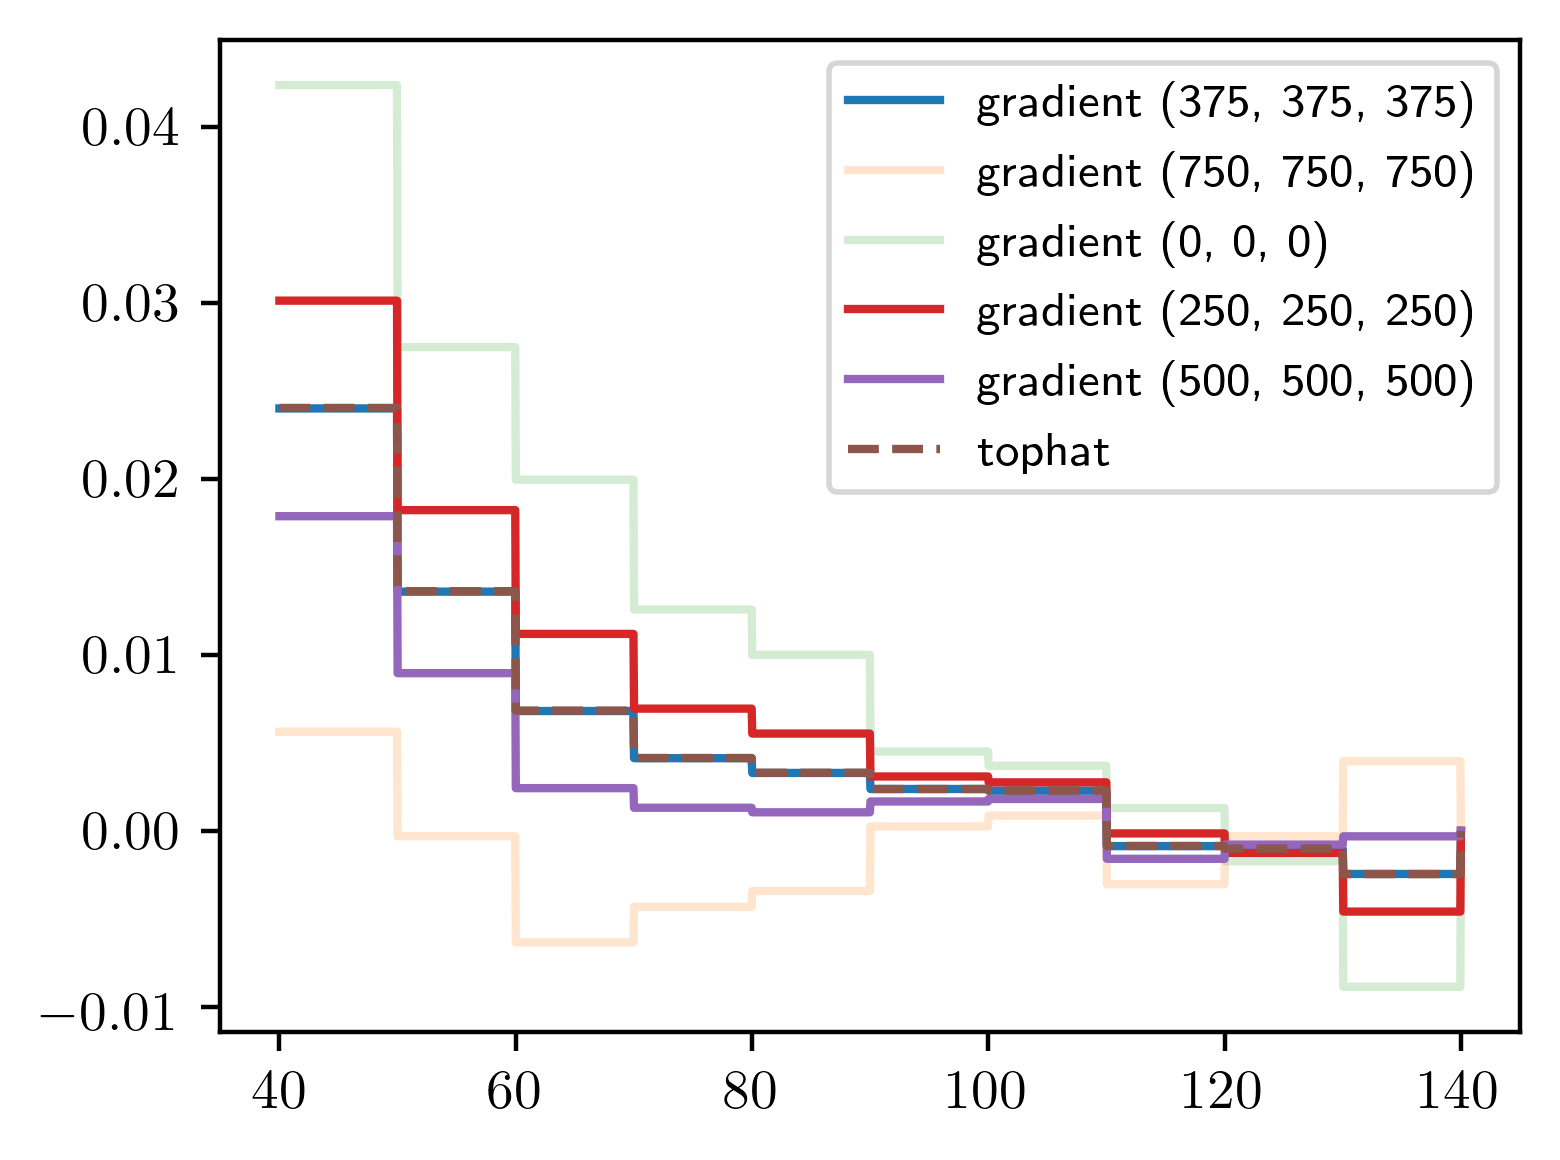

In [23]:
plt.plot(r_fine, xi_375, label='gradient (375, 375, 375)')
plt.plot(r_fine, xi_750, label='gradient (750, 750, 750)', alpha=0.2)
plt.plot(r_fine, xi_0, label='gradient (0, 0, 0)', alpha=0.2)
plt.plot(r_fine, xi_250, label='gradient (250, 250, 250)')
plt.plot(r_fine, xi_500, label='gradient (500, 500, 500)')
plt.plot(r_fine, xi_top, label='tophat', ls='--')
plt.legend()

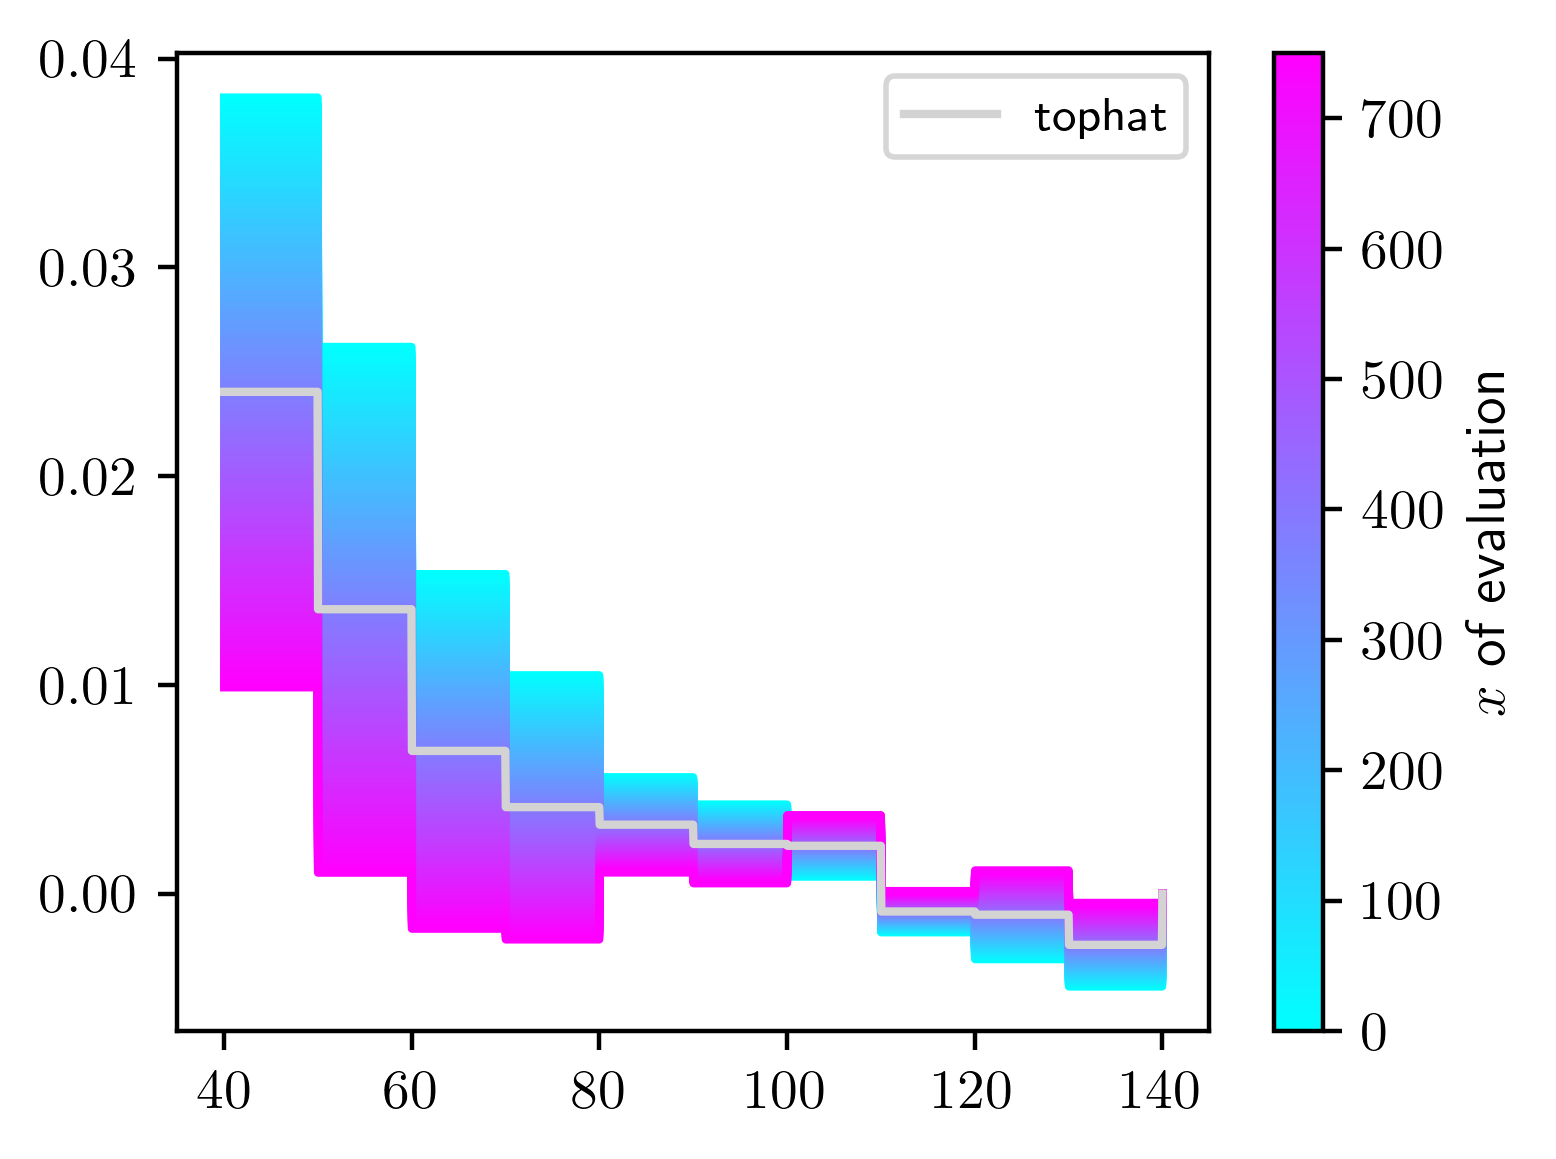

In [24]:
fig = plt.figure()
ax = plt.gca()

nlocs = 100
loc_min = 0.0
loc_max = 750.0
locs = np.linspace(loc_min, loc_max, nlocs)
locs_norm = matplotlib.colors.Normalize(vmin=loc_min, vmax=loc_max)
cmap = matplotlib.cm.get_cmap('cool')

for i, loc in enumerate(locs):
    weights1 = np.array([1.0, loc, 375.0, 375.0])
    weights2 = np.array([1.0, loc, 375.0, 375.0])
    xi_loc = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges, projfn=projfn, 
                     weights1=weights1, weights2=weights2, weight_type=weight_type)    
    
    p = plt.plot(r_fine, xi_loc, color=cmap(locs_norm(loc)))

plt.plot(r_fine, xi_top, label='tophat', ls='-', color='lightgrey')
plt.legend(loc='upper right')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, label=r'$x$ of evaluation')

The magnitude of each bin is the magnitude of the amplitude value associated with $x$ for that bin, where $x$ is the mean location of the galaxy pair. The direction of the $x$-dependence is the sign of the associated amplitude. 

The $x$-dependent amplitudes are the relative strength of clustering at that $x$ value. Galaxy pairs with larger $x$ locations will contribute a larger amount to that amplitude, while if they have an $x$ location near the pivot point, they will only contribute a small amount. The same goes for small $x$ locations. Thus if there were no gradient in the $x$ direction, we would expect small amplitudes that tell us there aren't disproportionately more large- or small-$x$ galaxies at a given separation scale.

This looks different for each mock realization! So we are seeing noise. We need to take some means to understand what's going on.

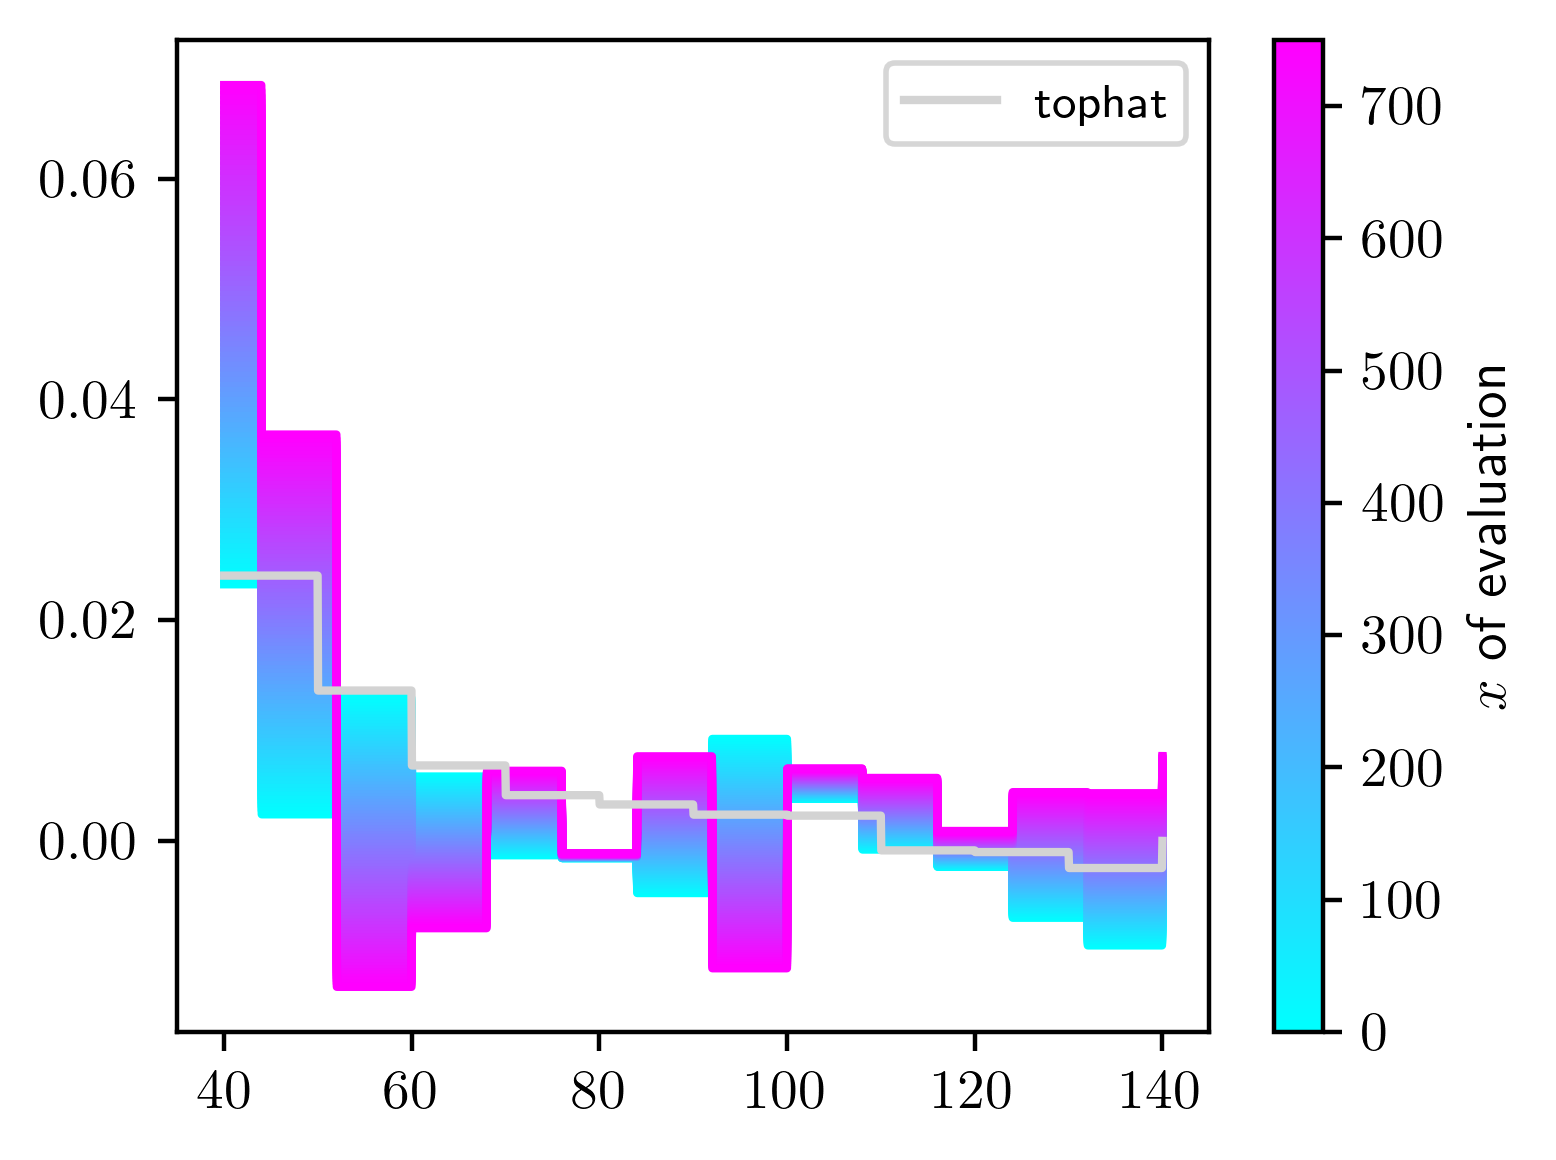

In [30]:
proj = 'gradient'
binwidth = 8
cf_tag = f"_{proj}_top_bw{binwidth}"
realizations = range(1)

qq_tag = '_qqnum'
cat_tag = '_L750_n5e-5_z057_patchy'
result_dir = f'../results/results_lognormal{cat_tag}'
for Nr in realizations:
    results_fn = f'{result_dir}/cf{cf_tag}{qq_tag}{cat_tag}_rlz{Nr}.npy'
    r, xi, amps, proj, extra_dict = np.load(results_fn, allow_pickle=True)
    r_edges = extra_dict['r_edges']
    
    fig = plt.figure()
    ax = plt.gca()

    nlocs = 100
    loc_min = 0.0
    loc_max = 750.0
    locs = np.linspace(loc_min, loc_max, nlocs)
    locs_norm = matplotlib.colors.Normalize(vmin=loc_min, vmax=loc_max)
    cmap = matplotlib.cm.get_cmap('cool')

    for i, loc in enumerate(locs):
        weights1 = np.array([1.0, loc, 375.0, 375.0])
        weights2 = np.array([1.0, loc, 375.0, 375.0])
        xi_loc = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges, projfn=projfn, 
                         weights1=weights1, weights2=weights2, weight_type=weight_type)    

        p = plt.plot(r_fine, xi_loc, color=cmap(locs_norm(loc)))

    plt.legend(loc='upper right')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
    plt.colorbar(sm, label=r'$x$ of evaluation')
    